# Approximation of the Ricci-flat metric on a manifold
In this example notebook we consider a simple complex manifold $X$, and approximate the metric tensor on $X$ by optimisation of a variational objective derived from a PDE the metric tensor should solve.

In more detail, the manifold $X$ is a Calabi-Yau threefold defined as a projective variety in $\mathbb{P}^5$. This is the (mirror of the) intersection of two cubics in the ambient $\mathbb{P}^5$.

We wish to approximate the unique Ricci-flat metric on $X$ - that is, one whose associated Ricci curvature vanishes. We sample points from the manifold and obtain an approximation to the Ricci-flat metric via optimisation of an objective constructed from the Monge-Ampere equation.

In [1]:
import jax
from jax import random
import jax.numpy as jnp

import os, time
import numpy as np

from cymyc.utils.pointgen_cicy import PointGenerator 

## Manifold definition
The manifold is explicitly defined as the zero locus of the following polynomials in the complex projective space $\mathbb{P}^5$, where we let $Z_i$ denote local coordinates in the ambient projective space;

\begin{align*}
P_1 &= Z_0^3 + Z_1^3 + Z_2^3 - 3 \psi Z_3 Z_4 Z_5~, \\
P_2 &= Z_3^3 + Z_4^3 + Z_5^3 - 3 \psi Z_0 Z_1 Z_2~.
\end{align*}

The single complex structure moduli direction corresponds to the trilinear polynomial deformations above, parameterised by $\psi \in \mathbb{C}$. We'll choose the point $\psi = 0.5$ in moduli space, which is away from singularities in the moduli space - see [this article for more details](https://arxiv.org/abs/2407.13836).

In [2]:
# Choose value of moduli parameter psi
psi = 0.5

monomials_1 = np.asarray([
    [3, 0, 0, 0, 0, 0],
    [0, 3, 0, 0, 0, 0],
    [0, 0, 3, 0, 0, 0],
    [0, 0, 0, 1, 1, 1]], dtype=np.int64)

monomials_2 = np.asarray([
    [0, 0, 0, 3, 0, 0],
    [0, 0, 0, 0, 3, 0],
    [0, 0, 0, 0, 0, 3],
    [1, 1, 1, 0, 0, 0]], dtype=np.int64)

monomials = [monomials_1, monomials_2]

cy_dim = 3
kmoduli = np.ones(1)
ambient = np.array([5])
dim = 6

coeff_fn = lambda psi: [np.append(np.ones(3), -3.0*psi), np.append(np.ones(3), -3.0*psi)]
coefficients = coeff_fn(psi)
poly_data = (monomials, cy_dim, kmoduli, ambient)

## Point sampling

We need to sample points from $X \hookrightarrow \mathbb{P}^n$ according to a known distribution in order to evaluate integrals via Monte Carlo integration. One way of doing this is to utilise the identification $\mathbb{P}^n \simeq S^{2n+1} / U(1)$.

First we sample uniformly from the sphere $S^{2n+1}$, obtaining a uniformly distributed sample over $\mathbb{P}^n$. Next, one constructs a line connecting pairs of points $p,q \in \mathbb{P}^n$, and identifies the points of intersection with the zero locus $\{P_i=0\}_i$. These points are distributed according to a quantifiable distribution $dA$ on $X$. We correct for the fact that these points are not uniformly distributed according to the canonical measure on $X$ by computing the associated importance weights [(Douglas et. al (2008))](https://doi.org/10.1063/1.2888403). 

In [3]:
seed = 42
rng = random.PRNGKey(seed)
rng, pg_rng, init_rng = random.split(rng, 3)
dpath = "data/X33_demo"

n_p = 400000  # Number of training points
v_p = 200000  # Number of validation points

import warnings
warnings.filterwarnings('ignore')

In [4]:
pg_cicy = PointGenerator(rng, cy_dim, monomials, ambient, coefficients, kmoduli)
cicy_pts = pg_cicy.sample_intersect_cicy(init_rng, n_p + v_p)
pg_cicy.export(dpath, cicy_pts, n_p, v_p, psi, poly_data, coefficients)

Generating 600000 points ...


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 150752 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 489872 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 603010 out of 603010 | elapsed:  2.9min finished


Max locus violation: 1.67721e-13
Using kmoduli, [1.]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.97it/s]


Volume 9*t_0**3
Volume at chosen Kahler moduli 9.0
kappa: 0.0393404


### Dataset metadata
Here we save the metadata associated with the generated points to disk.

In [5]:
from cymyc import dataloading
from cymyc.utils import gen_utils as utils
from cymyc.approx.default_config import config

class args(object):
    # specify training config. For more options, see `src/approx/default_config`
    name = 'X33_demo'
    learning_rate = 1e-4
    n_epochs = 128  # change as necessary!
    dataset = dpath
    batch_size = 1024
    n_units = [48,48,48,48]

# Override default arguments from config file with provided command line arguments
config = utils.override_default_args(args, config)
config = utils.read_metadata(config)  # load dataset metadata

np_rng = np.random.default_rng()
data_train, data_val, train_loader, val_loader, psi = dataloading.initialize_loaders_train(
    np_rng      = np_rng,
    data_path   = os.path.join(config.dataset, "dataset.npz"),
    batch_size  = config.batch_size)

Saving config file to experiments/X33_demo/X33_demo_METADATA.pkl
Dataset size: (400000, 12), kappa: 0.0393404
Vol[g]: 0.0277778, Vol[Ω]: 0.7060880


## Ricci-flat metric optimisation

In [6]:
import optax
from functools import partial

from cymyc.approx import models
from cymyc.approx.train import create_train_state, train_step, callback

### Model construction
Here we construct a spectral neural network to approximate the Ricci-flat metric. This constructed as an $\partial\overline{\partial}$-exact correction to the corresponding Kähler form of some reference metric, one which is easily computable [(Larfors et. al. (2022))](https://iopscience.iop.org/article/10.1088/2632-2153/ac8e4e/meta).
$$ \tilde{\omega} = \omega_{\text{ref}} + \partial \overline{\partial} \phi~.$$
Thus the task reduces to finding a globally defined function $\phi \in C^{\infty}(X)$ s.t. the metric corresponding to the approximating Kähler form $\tilde{\omega}$ satisfies the Ricci-flat condition, which says that the volume form induced by the metric coincides with the canonical volume form, up to a constant function,
$$ \omega^n \propto \Omega \wedge \overline{\Omega} ~.$$
This is a nonlinear PDE on $X$ for the function $\phi$ - we encode this condition into a variational objective, discretise this via a neural network ansatz, and optimise to obtain a parameterised function describing a approximately Ricci-flat $\tilde{\omega}$. Note we are not using the Ricci curvature as the objective itself, as evaluation of third-order derivatives of a neural network is quite expensive - this is possible with our library though. 

In more detail, our ansatz consists of a projection of the input data $p \in \mathbb{P}^n$ into a $\mathbb{C}^*$-invariant form, via the mapping $\alpha_{n}\colon \mathbb{P}^{n}	\longrightarrow \mathbb{C}^{n+1,n+1}$,
whose action on a general point $p\in [Z_0\colon Z_1\colon \dots\colon Z_{n}]\in\mathbb{P}^{n}$ is defined as:

$$\alpha_{n}(p) = \left[\begin{matrix}
		\displaystyle \frac{Z_0 \overline{Z_0}}{|Z|^2} && \displaystyle\frac{Z_0 \overline{Z_1}}{|Z|^2} && \dots && \displaystyle\frac{Z_0 \overline{Z_{n}}}{|Z|^2} \\
		\displaystyle\frac{Z_1 \overline{Z_0}}{|Z|^2}  && \displaystyle\frac{Z_1 \overline{Z_1}}{|Z|^2} && \dots && \displaystyle\frac{Z_1 \overline{Z_{n}}}{|Z|^2} \\
		\vdots && \vdots && \ddots && \vdots \\
		\displaystyle \frac{Z_{n} \overline{Z_0}}{|Z|^2} && \displaystyle\frac{Z_{n} \overline{Z_1}}{|Z|^2} && \dots && \displaystyle\frac{Z_{n} \overline{Z_{n}}}{|Z|^2}
	\end{matrix}\right] ~.$$
	
This is followed by the conversion to real coordinates and the application of a standard feedforward neural network as below - this ensures the overall function learnt is a well-defined function on the ambient projective space.

![spec_arch](assets/spectral_arch.png)

Further note that,

* The default architecture we use in all our experiments is a four-layer net with 48 units each and results are empirically insensitive to the exact choice of architecture/hyperparameters.
* The spectral layer adapts to the size of the input - therefore a projective variety with a higher-dimensional description of local coordinates on the ambient space entails an architecture of higher complexity.

Below we define the model and optimiser. 

In [7]:
key, _key = jax.random.split(rng)

metric_model = models.LearnedVector_spectral_nn_CICY(
    dim=dim, ambient=ambient, n_units=config.n_units)

g_FS_fn, g_correction_fn, *_ = models.helper_fns(config)

optimizer = optax.adamw(config.learning_rate)
metric_params, opt_state, init_rng = create_train_state(_key, metric_model, optimizer, data_dim=dim * 2)
# partial closure
metric_fn = partial(models.ddbar_phi_model, g_ref_fn=g_FS_fn, g_correction_fn=g_correction_fn)

t0 = time.time()
logger = utils.logger_setup('X33_demo', filepath=os.path.abspath(''))
logger.info(metric_model.tabulate(init_rng, jnp.ones([1, config.n_ambient_coords * 2])))

Compiling LearnedVector_spectral_nn.spectral_layer.


14:25:26 INFO - logger_setup: /home/jt796/github/cymyc/docs/examples
14:25:26 INFO - <module>: 
                     LearnedVector_spectral_nn_CICY Summary                     
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ path     ┃ module           ┃ inputs        ┃ outputs     ┃ params           ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│          │ LearnedVector_s… │ float64[1,12] │ float64[]   │                  │
├──────────┼──────────────────┼───────────────┼─────────────┼──────────────────┤
│ layers_0 │ Dense            │ float64[36]   │ float64[48] │ bias:            │
│          │                  │               │             │ float32[48]      │
│          │                  │               │             │ kernel:          │
│          │                  │               │             │ float32[36,48]   │
│          │                  │               │             │                  │
│          │ 

Compiling LearnedVector_spectral_nn.spectral_layer.


### Optimisation loop
This is fairly standard - note Jax is more bare-metal than other libraries, so we write the looping logic ourselves. 

`jit` compilation introduces a delay the first time the `train_step` function is called, but executes quickly when called subsequently. We pay an initial up-front cost for compilation of Python functions into a form efficiently executable by an accelerator, which will be repaid during the execution itself.

In [8]:
import time
from tqdm import tqdm
from collections import defaultdict

eval_interval = 5
storage = defaultdict(list)

try:
    device = jax.devices('gpu')[0]
except:
    device = jax.devices('cpu')[0]

with jax.default_device(device):
    logger.info(f"Running on {device}")
    
    for epoch in range(config.n_epochs):
        if (epoch % eval_interval == 0):
            val_loader, val_data = dataloading.get_validation_data(val_loader, config.batch_size, data_val, np_rng)
            storage = callback(epoch, t0, 0, val_data, metric_params, metric_fn, g_FS_fn, config, storage, logger, mode='VAL')
        
        if epoch > 0:
            train_loader = dataloading.data_loader(data_train, config.batch_size, np_rng)
    
        train_loader_it = tqdm(train_loader, desc=f"Epoch: {epoch}", total=data_train[0].shape[0]//config.batch_size,
                               colour='green', mininterval=0.1)
        for t, data in enumerate(train_loader_it):
            metric_params, opt_state, loss = train_step(data, metric_params, opt_state, metric_fn, optimizer, config.kappa)
            train_loader_it.set_postfix_str(f"loss: {loss:.5f}", refresh=False)

# save parameters to disk
utils.basic_ckpt(metric_params, opt_state, config.name, 'FIN')
utils.save_logs(storage, config.name, 'FIN')

14:25:26 INFO - <module>: Running on cuda:0


Compiling ddbar_phi_model
Compiling phi_head
Compiling LearnedVector_spectral_nn.spectral_layer.
Compiling ricci_measure


14:26:18 INFO - callback: [51.7s]: [VAL] | Epoch: 0 | Iter: 0 | chi_form: -147.8624+0.0102j | det_g: 0.0018 | einstein_norm: 4.0715 | kahler_loss: 0.0000 | monge_ampere_loss: 0.2222 | ricci_measure: 0.1323 | ricci_scalar: -2.6378 | ricci_tensor_norm: 0.1802 | sigma_measure: 0.3148 | vol_CY: 0.0279 | vol_Omega: 0.7042 | vol_loss: 0.0001
Epoch: 0:   0%|                                                                                                                                                                                                                                       | 0/390 [00:00<?, ?it/s]

Compiling ddbar_phi_model


Epoch: 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:00<00:00, 589.58it/s, loss: 0.02722]
14:26:28 INFO - callback: [61.9s]: [VAL] | Epoch: 5 | Iter: 0 | chi_form: -149.3161-0.0202j | det_g: 0.0017 | einstein_norm: 1.2555 | kahler_loss: 0.0000 | monge_ampere_loss: 0.0270 | ricci_measure: 0.0435 | ricci_scalar: -0.2172 | ricci_tensor_norm: 0.0606 | sigma_measure: 0.0381 | vol_CY: 0.0278 | vol_Omega: 0.7086 | vol_loss: 0.0000
Epoch: 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:00<00:00, 557.11it/s, loss: 0.02210]
14:26:34 INFO - callback: [67.2s]: [VAL] | Epoch: 10 | Iter: 0 | chi_form: -146.9219+0.0199j | det_g: 0.0018 | einstein_

## Sanity check

As a sanity check, we may verify that the resulting metric is approximately Ricci-flat by investigating the behaviour of the Ricci tensor $\textsf{Ric}$ and Ricci scalar $R$, defined in terms of the Riemann curvature tensor $\textsf{Riem} \in \Omega^2(X; \textsf{End}(T_X))$, respectively, over training:
\begin{align*}
\textsf{Ric}(X,Y) &= \textsf{Tr}\left(Z \mapsto \textsf{Riem}(Z,X)Y\right), \quad X, Y \in \Gamma(T_X)~,\\
R &= \textsf{Tr}(\textsf{Ric})~.
\end{align*}

In [9]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 14})
# remove if no local tex installation
plt.rcParams['text.usetex'] = True 
plt.rcParams['text.latex.preamble'] = r'\usepackage[cm]{sfmath} \usepackage{amssymb} \usepackage{mathrsfs} \usepackage{amsmath}'
plt.rcParams['font.sans-serif'] = 'cm'

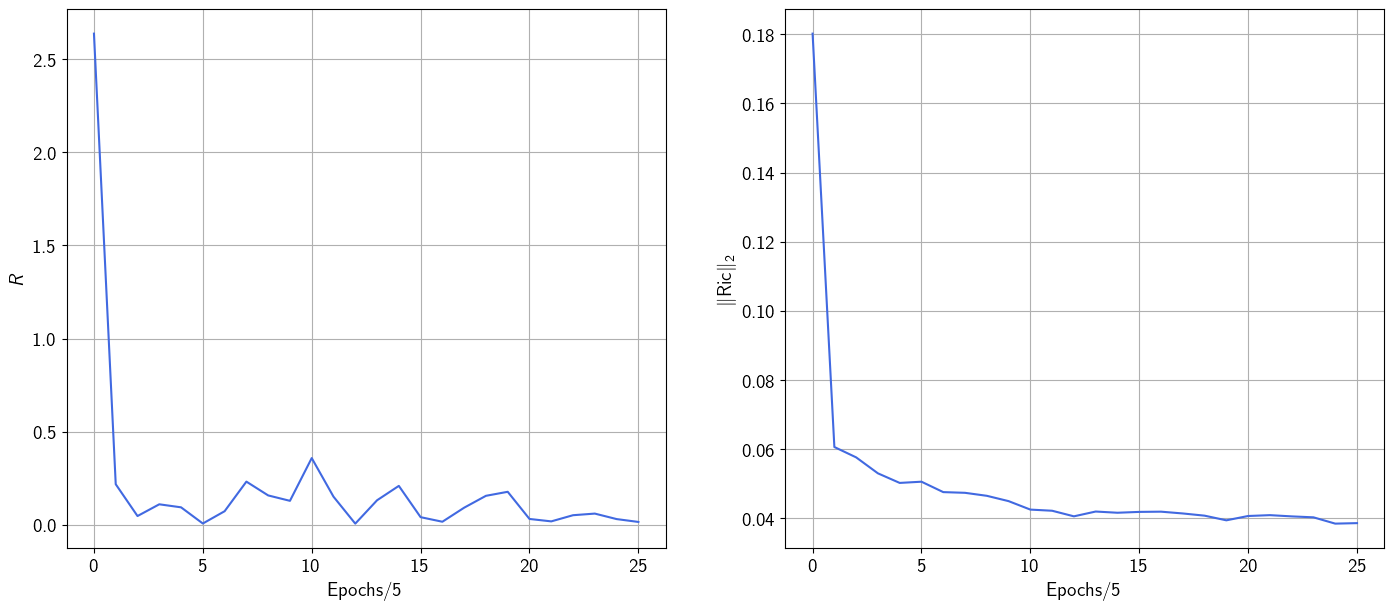

In [10]:
fig = plt.figure(figsize=(17,7))
gs=GridSpec(1,2)
ax1=fig.add_subplot(gs[0,0])
ax2=fig.add_subplot(gs[0,1])

S = np.abs(storage['ricci_scalar'])
n = 32
ax1.plot(np.arange(len(S))[:n], np.abs(S)[:n], c='royalblue')
ax1.set_xlabel(f'Epochs/{eval_interval}')
ax1.set_ylabel(r'$R$')
ax1.grid(True, 'both')

R = storage['ricci_tensor_norm']
ax2.plot(np.arange(len(R))[:n], np.abs(R)[:n], c='royalblue')
ax2.set_xlabel(f'Epochs/{eval_interval}')
ax2.set_ylabel(r'$\Vert \textsf{Ric} \Vert_2$')
ax2.grid(True, 'both')

Now that we have an approximation to the Ricci-flat metric on $X$, we can use this to do geometry - e.g. measure lengths, areas, volumes, and study the spectrum of various differential operators. See the `harmonic_forms` example notebook, where we use the learnt metric to find the zero modes of the Laplacian on $X$. 